# *TOY FITTER tutorial*

# In a nutshell:  Neymann construction with likelihood ratio

## Some definitions:
- **mu** is our parameter of interest, the signal strenght, it can be considered as equal to the number of signal events. Altough there is a small difference (out of the scope of this tutorial).
- **q_mu** is the test statistic, the likelihood ratio. This is a function of the "tested" value of **mu**.
- **H_mu** is the signal hypothesis with a signal strenght **mu**.
- **H_0** is the null hypothesis, background only.

## General Idea
Porduce limits with the Neymann construction method. Typically this means that one wants to reject the signal hypothesis **H_mu**  in favour of the null, **H_0**. The whole game is then to find the value of **mu** for which the **H_mu** is rejected at 90% CL. To do so one needs the distibution of the test statistic **q_{mu}** under signal hypothesis **H_mu** (assuming that **H_mu** is true).
The whole procedure is quite involved, but can be divided in a few points:

**Produce the 90% quantiles curve** 
- Produce several MC toy datasets related to a specific hypothesis **mu**.
- **Fit** those datastes, meaning, compute the **q_mu**, testing the same exact **mu** for under which the toys are generated
- Now you have many **q_mu** values for a given **mu** test and the related hypothesis. So you have the distro of **q_mu** under the hypothesis **H_mu**. So you can compute the 90% quantile of that distribution **q_mu_90**, or in other words the value of **q_mu** that correspond to a p-value of 10%.
- Now you can repeat the procedure for a prefixed set of values of **mu** and obtain a set of **q_mu_90** points.
- Interpolate the latter set of points and you'll have a curve describing the evolution of the 90% quantile of the test statistic **q_mu_90** as a function of the tested value of **mu**.
- Now you can use that curve to compute the limits.

**Compute the limits or the sensitivity**
- Given a dataset, that can be real data (for real limit) or toy bkg only data (for sensitivity), one compute the value of **q_mu** for a given **mu**.
- Check that value againts the **q_mu_90** curve to find if its p-value is larger than 10%, if yes that **mu** hypothesis is excluded.
- Find the value of **mu** for which the likelihood ratio curve **q_mu** intersect the **q_mu_90** curve, that is the limit at 90% CL.
- If you are computing the real limmit then you are done, if you are computing sensitivity then repeat these last 2 points for many toy datasets untill you'll get the distribution of limits under the **H_0**. Find the median and 1-2sigma of that distro.

# 1) The focus of this tutorial:

If you came here first, you probably want to start from the tutorial on [generation of toys](https://github.com/XENON1T/Xephyr/blob/master/notebooks/ToyGenerator_example.ipynb) instead. 

We want to produce the "alternate hypothesis" test statistic distributions: **f(q_mu | H_mu)**, where: 
- mu is the parameter of interest
- q_mu is the test statistic coputed for a value mu_test
So that reads: the distro of the test statistic for mu_test = mu_true given that the true hipothesis for mu is mu = mu_true (so given data distributed with mu = mu_true).

We compute  f(q_mu | H_mu) for many mu_test = mu_true values and extract their 90% quantile.

We compute a TGraph of those quantile that we can evaluate at each point.

To get the sensitivity we compute the limit of a set of toys for the hypothesis H_0 (no signal). This means we find for each of them the value of mu_test that gives **q_mu_H0 = 90_quantile( f(q_mu-test | H_mu-test) )**


## 2) The Setup:
First of all I suggest you to produce a single compilable macro that contains the likelihood you want to use, you can find in other tutorial how to define the likelihood [here](https://xenon1t.github.io/Xephyr/docs/tutorials.html). The idea of this macro is to define a function that you can use to retrieve the likelihood, so that you have it defined in one place only. You can get inspiration on how to write this function from [here](https://github.com/XENON1T/Xephyr/blob/master/examples/SR1Like/src/likelihoodDef.cxx).

This tutorial depends on the Models of SR1 repository and on the likelihood definition and data stored in a xephyr example,  so you need to download the SR1 repository **WARNING::Huge file!**.

```bash
cd XEPHYR_DIR
git clone git@github.com:XENON1T/SR1Results.git SR1  # SR1 official repository

source Xephyr/pacman/installExample.sh  SR1Like      # Install Xephyr example in local dir
```

In [2]:
.x ../loadXephyr.C



      =================== Welcome to Xephyr =====================
       Version 6.0 dated 10-Oct-2017, compiled with ROOT 6.14/00

(int) 0


In [3]:
// add path to include files to ROOT (in the file I'm going to load there are some Xephyr includes) 
gInterpreter->AddIncludePath("../src");  // in this case is just XEPHYR src from next dir.

###### now load the function to retrieve the likelihood

In [4]:
.L ../../xephyr_examples/SR1Like/src/likelihoodDef.cxx

In [5]:
double mass = 50.; // GeV
int likelihood_type = 0;  // [0=inner egg, 1= U volume, 2 = Wall volume]

// The whole SR1 likelihood definition now is in this object here
// There is a notebook about how to build the likelihood, check it out.
// IMPORTANT NOTE:   /!\ this function call is different from the previous tutorial
// this will load the likelihood with DM data and already initialized
pdfLikelihood *likeHood =  getDMLikelihood( mass , likelihood_type );


pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/ERBackgroundModel_Stitched_SR1_RunSourceCombinedFit180420.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Background_wall_ac_templates_v6_inegg_bin_SR1_2018-04-30.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Background_wall_ac_templates_v6_inegg_bin_SR1_2018-04-30.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/RadiogenicNRBackgroundModel_SR1_RunSourceCombined180420.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Ra

In [5]:
ToyFitterExclusion fitter("treeName");

In [6]:
fitter.setTheLikelihood(&likeHood);

In [7]:
double qstat = fitter.computeTS(0.1);  // computing the test statistic with preset value of data in the likelihood

Finding maximum of xe1T
Total of 3 active parameters, don't freeze parameters of interest, Minuit fits 3 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           0                 
  3 _RF                  Nuisance           0                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
ML -231.566 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest     0.24 +- 2.5      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.12 +- 1.3      
  3 _RF              

In [8]:
fitter.setPrintLevel(WARNING);   //  suppressing output to only WARNING (other possibilities are INFO, ERROR, DEBUG)

## 3) Fitting
### Fitting the Toy Generated Ntuple Tree list

In [9]:
// some settings
fitter.setInputDir("./");   // just to show how to change path to file (not needed), here we put same as constructor
fitter.setTreeName("treeName");         // toy tree name prefix to fit in file
fitter.setRandomizeMeasure(true);       // if randomize or not the nuissance parameter measure (default to true)

In [10]:
// void fit(double mu, int stopAt=-999)
fitter.fit(10);   

ToyExclusion::fit - INFO : Matched tree name, treeName0
ToyExclusion::measureParameters - INFO : Randomizing parameters:
ToyExclusion::----> - INFO : Skipping paramater: Sigma
ToyExclusion::----> - INFO : Skipping paramater: ERscale
ToyExclusion::----> - INFO : new T0-Value: _PY = 1.95
ToyExclusion::----> - INFO : new T0-Value: _RF = -1.29
ToyExclusion::----> - INFO : Skipping paramater: _gamma_
ToyExclusion::----> - INFO : Skipping paramater: _alpha_
ToyExclusion::----> - INFO : Skipping paramater: _eta_
ToyExclusion::----> - INFO : Skipping paramater: _acceptance_par_
ToyExclusion::computeTS - DEBUG : maximize Data_treeName0 --> dmData
Finding maximum of xe1T
Total of 3 active parameters, don't freeze parameters of interest, Minuit fits 3 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance     

ML -318.895 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      6.6 +- 4.5      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         1.7 +- 0.38     
  3 _RF                  Nuisance       -0.57 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      6.6                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         1.7                 
  3 _RF                  Nuisance       -0.57                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

ML -306.041 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      5.2 +- 3.7      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         0.5 +- 0.056    
  3 _RF                  Nuisance        -1.8 +- 3.4      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      5.2                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         0.5                 
  3 _RF                  Nuisance        -1.8                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

ML -330.38 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      4.1 +- 3.5      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.17 +- 1        
  3 _RF                  Nuisance        -1.4 +- 1.1      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      4.1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.17                 
  3 _RF                  Nuisance        -1.4                 
  4 _gamma_              Fixed              0                 
  5 _alpha_ 

Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
ML -309.984 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      6.9 +- 4.8      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         1.2 +- 0.017    
  3 _RF                  Nuisance       

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -310.458 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen            10                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         0.5 +- 0.006    
  3 _RF                  Nuisance       -0.53 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen            10                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         0.5                 
  3 _RF                  Nuisance       -0.53                 
  4 _gamma_              Fixed              0                 
  5 _al

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


### Having a look at output fit file
This contains a tree, the tree has an entry for each input Toy tree. Each entry contains the post fit values for NP, likelihood and test statistic. In the example below I just hadded a few of these trees for different mu_fit [2.5,3,3.5,4], so now we can have a look at some distros.

In [11]:
TFile *f = TFile::Open("post_fit_test.root");
TTree *postFitTree  = (TTree*) f->Get("out_test");

In [12]:
postFitTree->Print();

******************************************************************************
*Tree    :out_test  : output tree for a given mu, hadd me                    *
*Entries :     4000 : Total =         1544931 bytes  File  Size =     321732 *
*        :          : Tree compression factor =   4.81                       *
******************************************************************************
*Br    0 :mu_fit    : mu_fit/D                                               *
*Entries :     4000 : Total  Size=      32794 bytes  File Size  =        656 *
*Baskets :        4 : Basket Size=      32000 bytes  Compression=  49.25     *
*............................................................................*
*Br    1 :q_mu      : testStat/D                                             *
*Entries :     4000 : Total  Size=      32790 bytes  File Size  =      18474 *
*Baskets :        4 : Basket Size=      32000 bytes  Compression=   1.75     *
*...................................................

#### We can now plot for example the distro of mu_hat for a certain value of Toy generated mu (true mu)
mu_hat is the first parameter of the unconditional fit

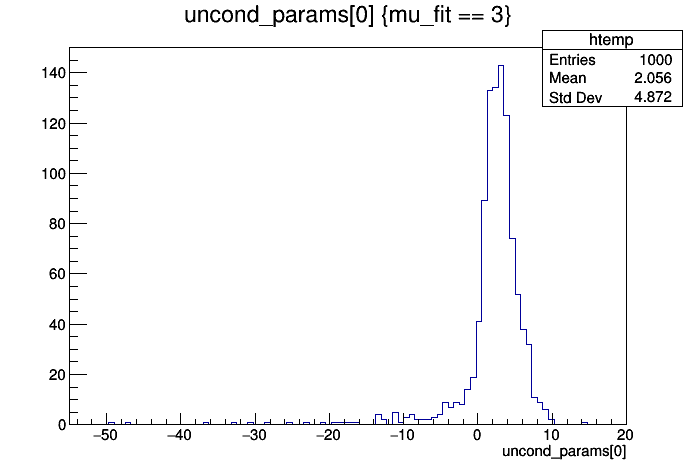

In [13]:
TCanvas *can = new TCanvas();
postFitTree->Draw("uncond_params[0]","mu_fit == 3");
can->Draw();

#### printout of all parameters

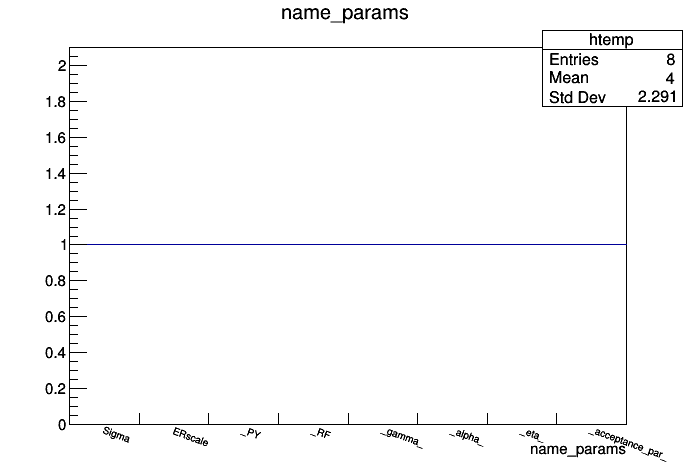

In [14]:
postFitTree->Draw("name_params","","",1);
can->Draw();

### example of unconditional pulls for RF

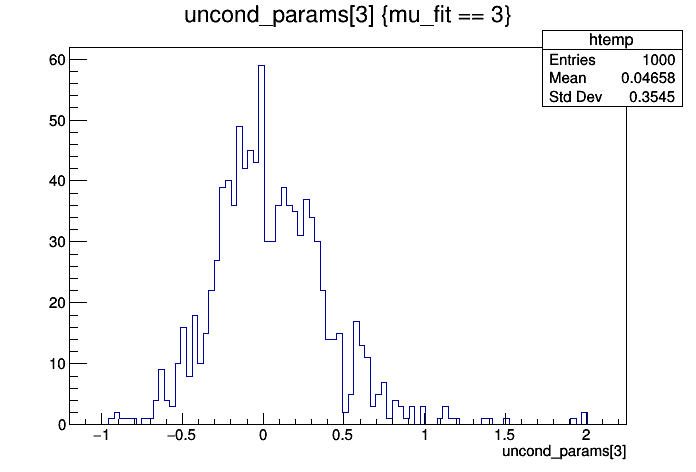

In [15]:
postFitTree->Draw("uncond_params[3]","mu_fit == 3");
can->Draw();

#### Or test statistic distributions

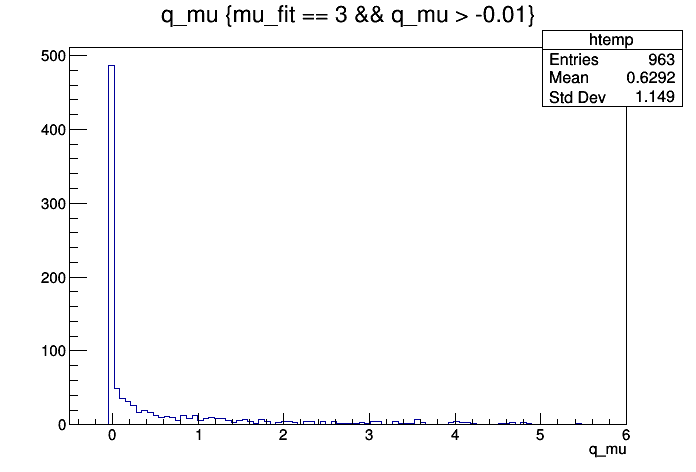

In [16]:
postFitTree->Draw("q_mu","mu_fit == 3 && q_mu > -0.01");  // at the time of writing there is probably a bug here
can->Draw();

## 4) Generating the 90% quantiles curve needed for limits

In [17]:
double mu_lista[4]   =  { 2.5, 3., 3.5, 4. };    // list of true mu hypothesis that we fitted (tested)
TGraphAsymmErrors quantiles ( fitter.computeTSDistros(postFitTree, mu_lista, 4 ) );

quantiles: 0.50 	 0.88 	 0.90 	 0.92 	
           0.014 	 2.405 	 2.693 	 3.079 	
quantiles: 0.50 	 0.88 	 0.90 	 0.92 	
           0.015 	 1.918 	 2.302 	 2.785 	


Info in <TCanvas::Print>: pdf file quantiles.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file quantiles.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file quantiles.pdf


quantiles: 0.50 	 0.88 	 0.90 	 0.92 	
           0.009 	 1.896 	 2.196 	 2.693 	
quantiles: 0.50 	 0.88 	 0.90 	 0.92 	
           0.000 	 1.899 	 2.274 	 2.653 	


Info in <TCanvas::Print>: Current canvas added to pdf file quantiles.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file quantiles.pdf
Info in <TCanvas::Print>: pdf file quantiles.pdf has been closed


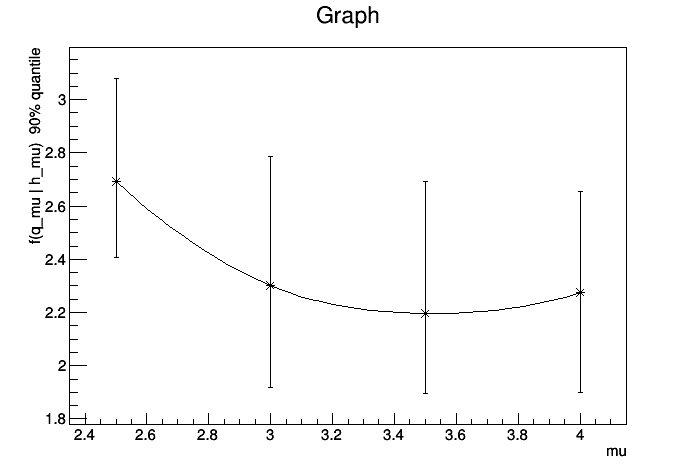

In [18]:
quantiles.GetXaxis()->SetTitle("mu");
quantiles.GetYaxis()->SetTitle("f(q_mu | h_mu)  90% quantile");
quantiles.Draw("AC*");
can->Draw();

### What do we do with it?
given a toy dataset generated under null hypothesis,  we compute q_mu for it, let's say for mu_test = 2.8, then mu = 2.8 is excluded @ >= 90% CL (given that dataset only) if the obtained q_mu >= 2.4

## 5) Limits and sensitivity bands

In [19]:
// some settings
fitter.setInputDir("./");               // just to show how to change path to file (not needed), here we put same as constructor
fitter.setTreeName("null_hypo");         // toy tree name prefix to fit in file
fitter.setRandomizeMeasure(true);       // if randomize or not the nuissance parameter measure (default to true)

In [20]:
// spitTheLimit(TGraphAsymmErrors *ninety_quantiles, int stopAt )
// :::WARNING::: this will take long time ;)
fitter.spitTheLimit(&quantiles, 10  );

ToyExclusion::fit - INFO : Matched tree name, null_hypo0
ToyExclusion::measureParameters - INFO : Randomizing parameters:
ToyExclusion::----> - INFO : Skipping paramater: Sigma
ToyExclusion::----> - INFO : Skipping paramater: ERscale
ToyExclusion::----> - INFO : new T0-Value: _PY = -1.23
ToyExclusion::----> - INFO : new T0-Value: _RF = 1.17
ToyExclusion::----> - INFO : Skipping paramater: _gamma_
ToyExclusion::----> - INFO : Skipping paramater: _alpha_
ToyExclusion::----> - INFO : Skipping paramater: _eta_
ToyExclusion::----> - INFO : Skipping paramater: _acceptance_par_
ToyExclusion::computeTS - DEBUG : maximize Data_null_hypo0 --> Data_treeName9
Finding maximum of xe1T
Total of 3 active parameters, don't freeze parameters of interest, Minuit fits 3 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nui

ML -188.438 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5 +- 0.0072   
  3 _RF                  Nuisance         0.6 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5                 
  3 _RF                  Nuisance         0.6                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -187.282 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             3                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance          -1 +- 0.0025   
  3 _RF                  Nuisance        0.61 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             3                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance          -1                 
  3 _RF                  Nuisance        0.61                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -187.862 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5 +- 0.0065   
  3 _RF                  Nuisance         0.6 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5                 
  3 _RF                  Nuisance         0.6                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -238.374 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5 +- 0.016    
  3 _RF                  Nuisance       -0.35 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5                 
  3 _RF                  N

ML -241.697 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5 +- 0.014    
  3 _RF                  Nuisance       -0.38 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5                 
  3 _RF                  Nuisance       -0.38                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -238.374 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5 +- 0.016    
  3 _RF                  Nuisance       -0.35 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.6                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5                 
  3 _RF                  N

ML -239.902 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5 +- 0.01     
  3 _RF                  Nuisance       -0.36 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        -0.5                 
  3 _RF                  Nuisance       -0.36                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -250.557 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      2.3 +- 3        
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.15 +- 1.1      
  3 _RF                  Nuisance       -0.38 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      2.3                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.15                 
  3 _RF                  Nuisance       -0.38                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

ML -250.798 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.053 +- 1.1      
  3 _RF                  Nuisance       -0.41 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.053                 
  3 _RF                  Nuisance       -0.41                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -250.798 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.053 +- 1.1      
  3 _RF                  Nuisance       -0.41 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.053                 
  3 _RF                  Nuisance       -0.41                 
  4 _gamma_              Fixed              0                 
  5 _al

Info in <Minuit2>: MnGlobalCorrelationCoeff: inversion of matrix fails.
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -217.618 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.68 +- 1.1      
  3 _RF                  Nuisance       0.075 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.68                 
  3 _RF                  N

ML -220.759 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75 +- 0.96     
  3 _RF                  Nuisance       0.029 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75                 
  3 _RF                  Nuisance       0.029                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -217.618 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.68 +- 1.1      
  3 _RF                  Nuisance       0.075 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.6                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.68                 
  3 _RF                  N

ML -219.292 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.72 +- 1.1      
  3 _RF                  Nuisance       0.048 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.72                 
  3 _RF                  Nuisance       0.048                 
  4 _gamma_              Fixed              0                 
  5 _al

Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::comp

ML -219.062 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75 +- 0.0036   
  3 _RF                  Nuisance        0.21 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75                 
  3 _RF                  Nuisance        0.21                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -216.962 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75 +- 0.0016   
  3 _RF                  Nuisance        0.22 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75                 
  3 _RF                  N

ML -218.637 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             2                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75 +- 0.0044   
  3 _RF                  Nuisance        0.21 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             2                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75                 
  3 _RF                  Nuisance        0.21                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -216.962 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75 +- 0.0016   
  3 _RF                  Nuisance        0.22 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.75                 
  3 _RF                  N

ML -219.839 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.64 +- 0.78     
  3 _RF                  Nuisance         1.4 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.64                 
  3 _RF                  N

ML -222.077 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.65 +- 0.78     
  3 _RF                  Nuisance         1.4 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.65                 
  3 _RF                  Nuisance         1.4                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -219.839 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.64 +- 0.78     
  3 _RF                  Nuisance         1.4 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.64                 
  3 _RF                  N

ML -221.364 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.7                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.64 +- 0.78     
  3 _RF                  Nuisance         1.4 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.7                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.64                 
  3 _RF                  Nuisance         1.4                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -231.664 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      0.5 +- 2.2      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1 +- 0.043    
  3 _RF                  Nuisance         1.1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      0.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1                 
  3 _RF                  Nuisance         1.1                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.154 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1 +- 0.03     
  3 _RF                  Nuisance           1 +- 1.4      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1                 
  3 _RF                  Nuisance           1                 
  4 _gamma_              Fixed              0                 
  5 _al

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.829 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1 +- 0.0084   
  3 _RF                  Nuisance           1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1                 
  3 _RF                  Nuisance           1                 
  4 _gamma_              Fixed              0                 
  5 _al

Info in <Minuit2>: MnGlobalCorrelationCoeff: inversion of matrix fails.
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.721 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1 +- 0.02     
  3 _RF                  Nuisance        0.99 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1                 
  3 _RF                  Nuisance        0.99                 
  4 _gamma_              Fixed              0                 
  5 _al

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.784 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1 +- 0.0095   
  3 _RF                  Nuisance           1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance           1                 
  3 _RF                  Nuisance           1                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -210.684 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      -35 +- 2.7      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.92 +- 0.41     
  3 _RF                  Nuisance       0.098 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      -35                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.92                 
  3 _RF                  Nuisance       0.098                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -238.815 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -4.4e-06 +- 0.057    
  3 _RF                  Nuisance      -0.091 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             1                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -4.4e-06                 
  3 _RF                  N

ML -242.47 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance      -5e-06 +- 0.054    
  3 _RF                  Nuisance      -0.093 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance      -5e-06                 
  3 _RF                  Nuisance      -0.093                 
  4 _gamma_              Fixed              0                 
  5 _alp

ML -238.815 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -4.4e-06 +- 0.057    
  3 _RF                  Nuisance      -0.091 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.6                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -4.4e-06                 
  3 _RF                  N

ML -240.416 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -3.1e-06 +- 0.054    
  3 _RF                  Nuisance      -0.092 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -3.1e-06                 
  3 _RF                  Nuisance      -0.092                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -238.815 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -4.4e-06 +- 0.057    
  3 _RF                  Nuisance      -0.091 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance    -4.4e-06                 
  3 _RF                  N

ML -210.691 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         0.5 +- 0.24     
  3 _RF                  Nuisance       -0.13 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance         0.5                 
  3 _RF                  Nuisance       -0.13                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -211.227 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.46 +- 1        
  3 _RF                  Nuisance       -0.19 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.46                 
  3 _RF                  Nuisance       -0.19                 
  4 _gamma_              Fixed              0                 
  5 _al

Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb <= 0 
ML -185.548 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      -34 +- 2.8      
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance        0.51 +- 0.48     
  3 _RF                  Nuisance       -0.45 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      -34                 
  1 ERscale              Fixed        

ML -209.696 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25 +- 0.25     
  3 _RF                  Nuisance        -1.1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             4                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  N

ML -211.368 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25 +- 0.54     
  3 _RF                  Nuisance        -1.1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance        -1.1                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -209.696 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25 +- 0.25     
  3 _RF                  Nuisance        -1.1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.8                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  N

ML -211.307 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25 +- 0.33     
  3 _RF                  Nuisance        -1.1 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance        -1.1                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -239.531 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.061 +- 1.1      
  3 _RF                  Nuisance       -0.27 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.061                 
  3 _RF                  N

ML -241.631 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.031 +- 1.1      
  3 _RF                  Nuisance       -0.28 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           2.5                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.031                 
  3 _RF                  Nuisance       -0.28                 
  4 _gamma_              Fixed              0                 
  5 _al

ML -239.531 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             0                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.061 +- 1.1      
  3 _RF                  Nuisance       -0.27 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Finding maximum of xe1T
Total of 3 active parameters,  freeze parameters of interest, Minuit fits 2 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             2                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.061                 
  3 _RF                  N

ML -241.148 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.038 +- 1.1      
  3 _RF                  Nuisance       -0.27 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.9                 
  1 ERscale              Fixed              0                 
  2 _PY                  Nuisance       0.038                 
  3 _RF                  Nuisance       -0.27                 
  4 _gamma_              Fixed              0                 
  5 _al